# Machine Learning for Post-Processing NWM Data 
**Authors: Savalan Naser Neisary (PhD Student, CIROH & The University of Alabama)**




### 1. Introduction 
#### 1.1. Overview of the Workshop’s Goals and Structure.

This is going to be 90 minutes workshop in which we will:
- An overview of ML model development in SageMaker.
- Learn how to develop a simple Long-Short-Term Memory (LSTM) on SageMaker to post-process NWM data. 
- Learn how to use different CPUs and GPUs. 
- Learn how to use Git, Conda, and Amazon S3 buckets in our model development process.


We will first review the theoretical background behind the LSTM and the pros and cons of the most powerful LSMT algorithm. Then, we will start the hands-on part of the workshop. Next, we plan to preprocess the data and start model development using the Pytorch library. After that, we will discuss hyperparameter tuning. Finally, we will evaluate and compare the model with NWM results. 
#### 1.2. Post-processing Hydrological Predictions

Effective and sustainable management of water resources is crucial to provide adequate water supply for human societies, regardless of their geographical location. Having an accurate and precise prediction of future hydrological variables, including streamflow, is a critical component for effective water systems management, and various studies presented different methods, such as post-processing, to increase the accuracy of the hydrological predictions. Post-processing methods seek to quantify the uncertainties of hydrological model outcomes and correct their biases using a statistical model to transform model outputs based on the relationship(s) between observations and model. According to the literature, Machine Learning (ML) models have proved useful in post-processing the results of other ML or physical-based hydrological models. Therefore, in this workshop, we will use LSTM to post-process streamflow outputs of a physical-baed model. 
#### 1.3. Post-processing Retrospective National Water Model (NWM) Streamflow Data

NOAA introduced the NWM to address the need for an operational large-scale hydrological forecasting model to provide streamflow predictions in CONUS. While it can predict streamflow in 2.7 billion water reaches, according to the literature, NWM has low accuracy in regions west of the 95th meridian with drought and low-flow problems and in controlled basins with extensive water infrastructure. This low performance in western US watersheds is due to the lack of water operation consideration and a comprehensive groundwater and snow model besides calibrating NWM, mostly with watersheds in the eastern US. To compensate for NWM shortcomings in this workshop, we will demonstrate how to use LSTM to increase accuracy by post-processing the NWM outputs and adding the human activity impact.   

###### Recommended Resources:
- Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow.
- C4.5: Programs for Machine Learning.
- A Holistic Comparative Application of Artificial Intelligence Methods in Reservoir Inflow Forecast. 






### 2. Theoretical Background 

#### 2.1. Long Short Term Memory (LSTM)
Long Short-Term Memory networks, commonly known as LSTMs, are a special kind of recurrent neural network (RNN) capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber in 1997 and have since been a fundamental component in the progression of deep learning, particularly in sequences and time series data. LSTMs are designed to avoid the long-term dependency problem, allowing them to remember information for extended periods. This is crucial in tasks such as language translation, speech recognition, and time series forecasting where the context and past information significantly influence the current output.

LSTMs achieve this capability through a complex architecture that includes several gates: the input gate, the forget gate, and the output gate. Each gate in an LSTM cell regulates the flow of information, deciding what to retain and what to discard, thus effectively maintaining the cell state across time steps. The gates are composed of sigmoid neural net layers that output numbers between zero and one, describing how much of each component should be let through. This gating mechanism differentiates LSTMs from other neural networks by giving them finer control over the gradient flow and state updates, which helps in maintaining stable gradients over time, thereby making them highly effective for tasks involving sequential data.

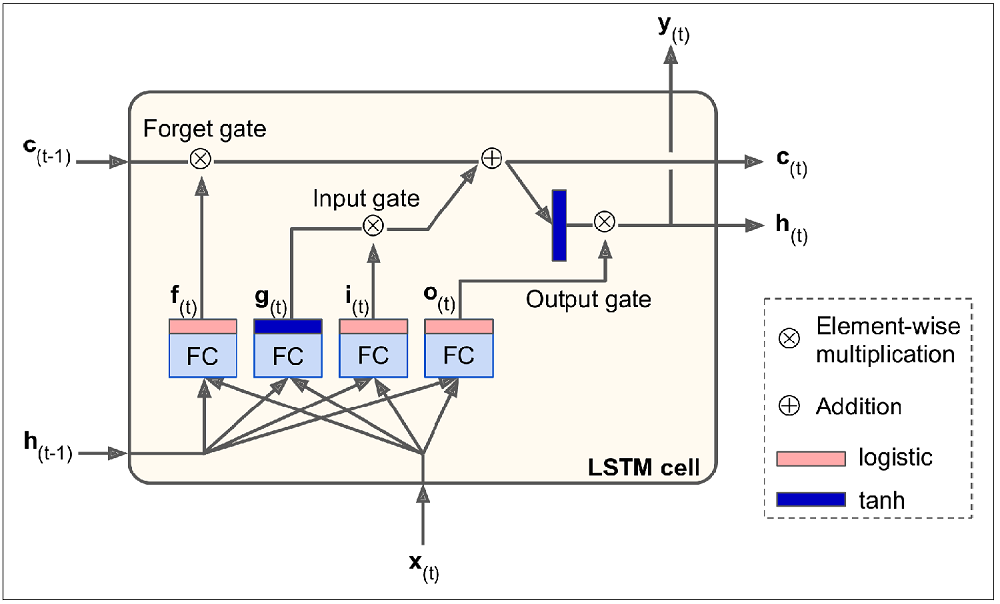


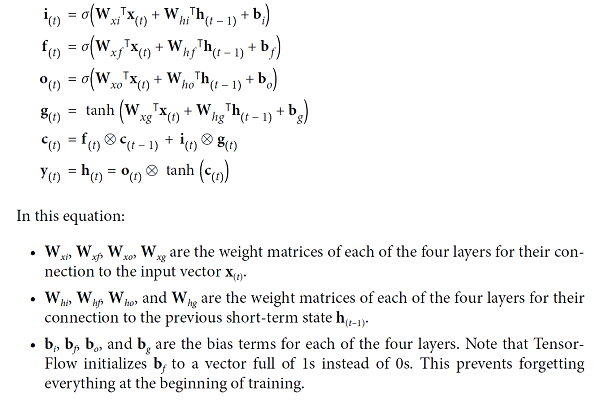


## 3. Data Preprocessing
#### 3.1. Overview of the USGS Stream Station
- The dataset we will use provides the data for several stations in the Great Salt Lake (GSL) watershed. 
- The dataset contains climate variables, such as precipitation and temperature, water infrastructure, storage percentage, and watershed characteristics, such as average area and elevation. 
You can see the location of the station and its watershed in the Figure below. 

In [1]:
# my packages
from evaluation_table import EvalTable
from figure_generator import EvalPlot
from model import CustomBiLSTM
from tuning_tools import tuning_game, tune_model 
from data_preprocess import data_prepare, data_split
from final_eval import general_viz, regime_eval, signature_eval, eval_drought

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import joblib

# system packages
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time
from tqdm import tqdm
import os

# hydrological packages
import hydroeval as he
from hydrotools.nwm_client import utils # I had to pip install this

# data analysis packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Identify the path
home = os.getcwd()
parent_path = os.path.dirname(home)
input_path = f'{parent_path}/02.input/'
output_path = f'{parent_path}/03.output/'
main_path = home

/home/jovyan/envs/devcon_2025/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


#### 3.2. Load Dataset

In [2]:
# List of station IDs that are of interest.
stations = ['10154200', '10155000', '10156000']
# stations = ['10011500', '10068500', '10126000']
# Read a CSV file into a DataFrame and set the first column as the index.
df = pd.read_parquet(f'{input_path}data_model_input.parquet')

# Convert the station_id column to string data type.
df.station_id = df.station_id.astype(str)

# Convert the 'datetime' column to datetime objects.
df.datetime = pd.to_datetime(df.datetime)
# df = df[df['swe'] != 0]
# Filter the DataFrame to include only the rows where 'station_id' is in the 'stations' list.
dataset = df[df['station_id'].isin(stations)]

# Extract a list of unique station IDs from the modified dataset.
station_list = dataset.station_id.unique()


#### 3.3. Visualizing the Data
- The takeaway from data visualization is to gather information about data distribution, outliers, missing values, correlation between different variables, and time dependencies between variables.
- Here, we will use boxplots, histograms, and combo bar and line plots to show outliers, distribution, and time dependencies in streamflow, precipitation, temperature, and SWE.

First, we will plot the time dependencies using bar and line plots for streamflow vs precipitation and SWE. 

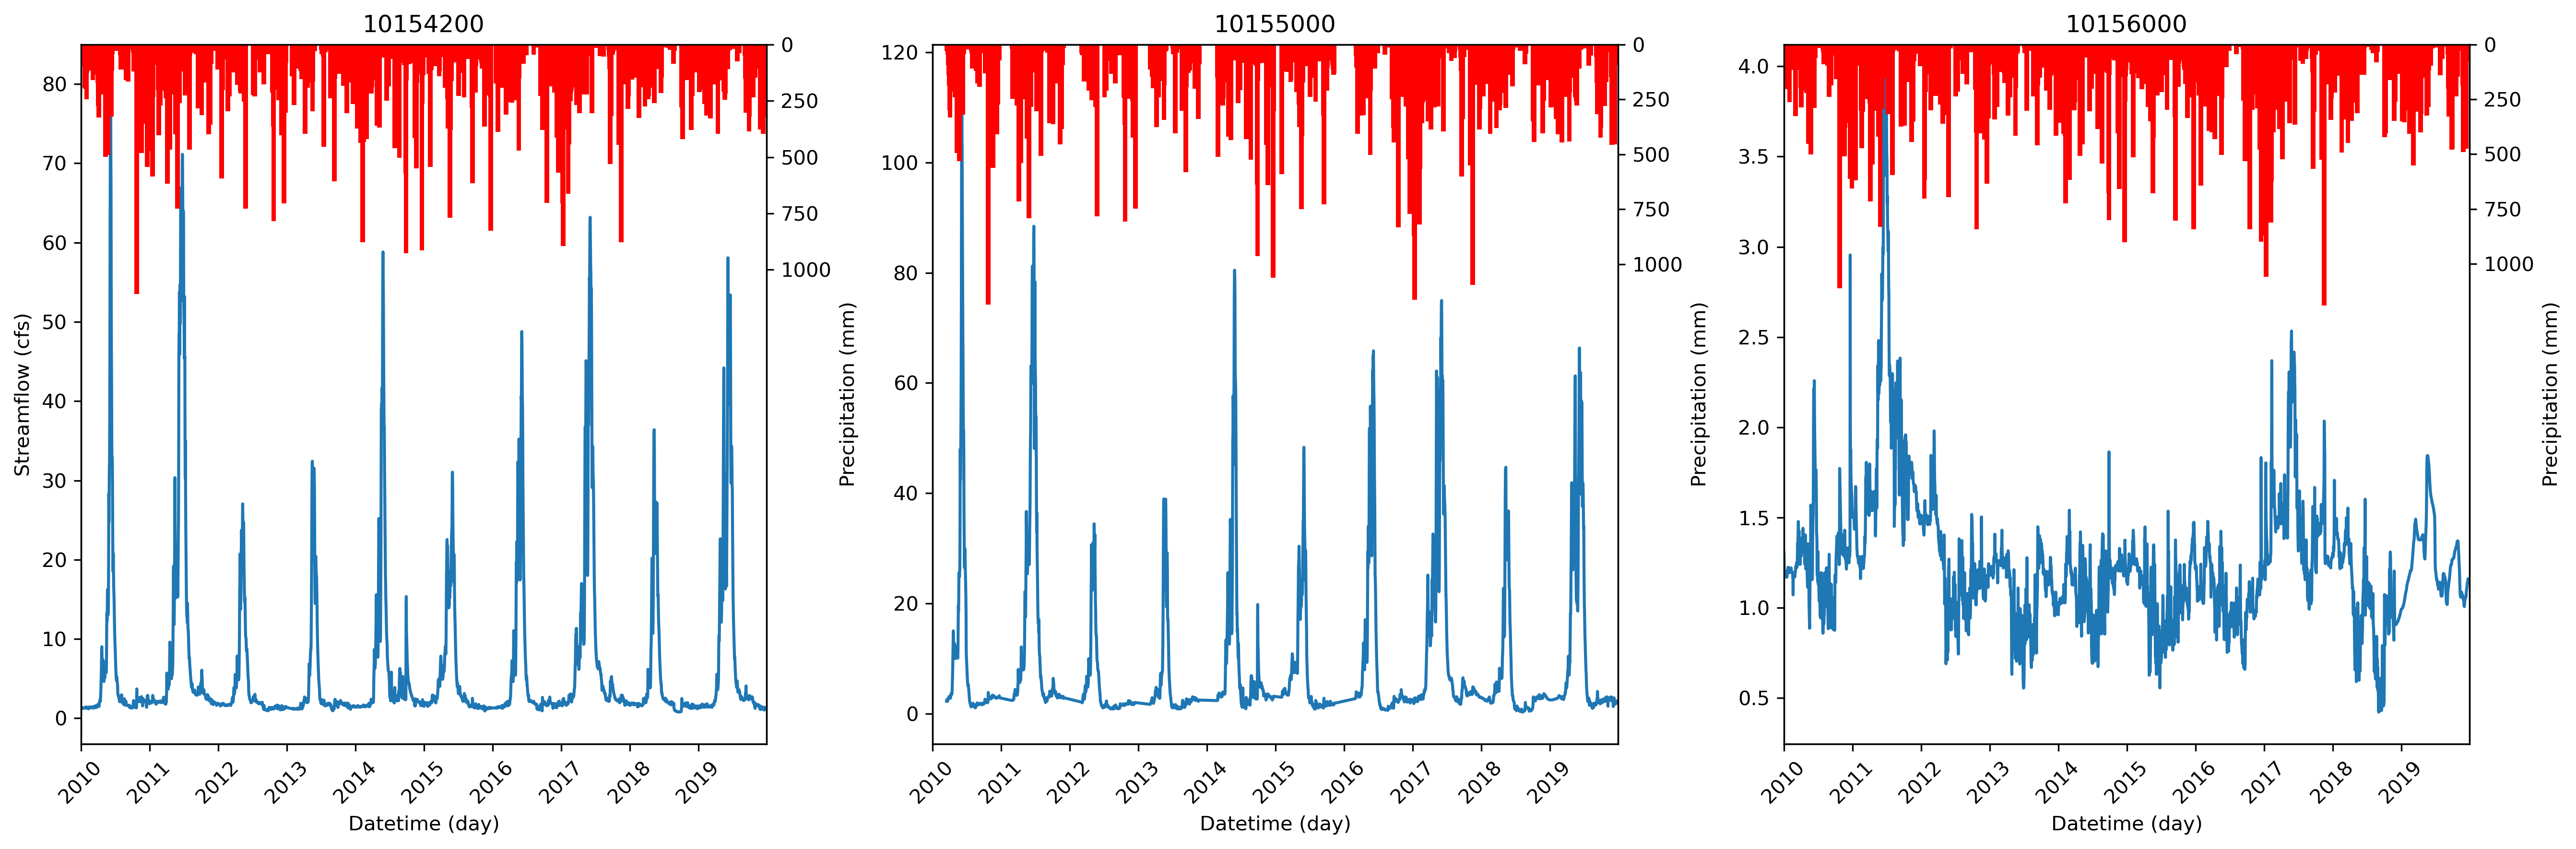

CPU times: user 11.5 s, sys: 146 ms, total: 11.7 s
Wall time: 11.7 s


In [3]:
%%time
# Calculate the number of subplots needed based on the number of unique stations.
n_subplots = len(station_list)
# Determine the number of columns in the subplot grid by taking the ceiling of the square root of 'n_subplots'.
n_cols = 3#int(math.ceil(math.sqrt(n_subplots)))
# Determine the number of rows in the subplot grid by dividing 'n_subplots' by 'n_cols' and taking the ceiling of that.
n_rows = int(math.ceil(n_subplots / n_cols))
# Set the figure size for the subplots.
figsize = (18, 6)
# Create a grid of subplots with specified number of rows and columns and figure size.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=300)
# Flatten the axes array for easier iteration.
axes = axes.flatten()

# Iterate over the axes to plot the data for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:
        year = 2010
        # Extract the data for the current station from the dataset.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]
        temp_df_1 = temp_df_1[(temp_df_1.datetime.dt.year >= year) & (temp_df_1.datetime.dt.year < year+10)]
        # Set 'datetime' as the index for plotting.
        temp_df_2 = temp_df_1.set_index('datetime')
        # Plot the 'flow_cfs' data on the primary y-axis.
        ax.plot(temp_df_2.index, temp_df_2['flow_cms'])
        # Set the x-axis limits from the first to the last year of data.
        start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
        end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
        ax.set_xlim(start_year, end_year)
        # Rotate x-axis labels for better readability.
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45)

        # Create a second y-axis for the precipitation data.
        ax2 = ax.twinx()
        # Plot the 'precip(mm)' data as a bar graph on the secondary y-axis.
        ax2.bar(temp_df_2.index, temp_df_2['precipitation'], label='Inverted', color='red', width=25)
        # Set the y-axis limits for precipitation, flipping the axis to make bars grow downward.
        ax2.set_ylim(max(temp_df_2['precipitation']) + 2000, 0)
        # Set the label for the secondary y-axis.
        ax2.set_ylabel('Precipitation (mm)')
        # Define custom ticks for the secondary y-axis.
        ax2.set_yticks(np.arange(0, max(temp_df_2['precipitation']), 250))

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Datetime (day)')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Streamflow (cfs)')
    else:
        # Hide any unused axes.
        ax.axis('off')

# Adjust layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


The next plot shows SWE vs streamflow. 

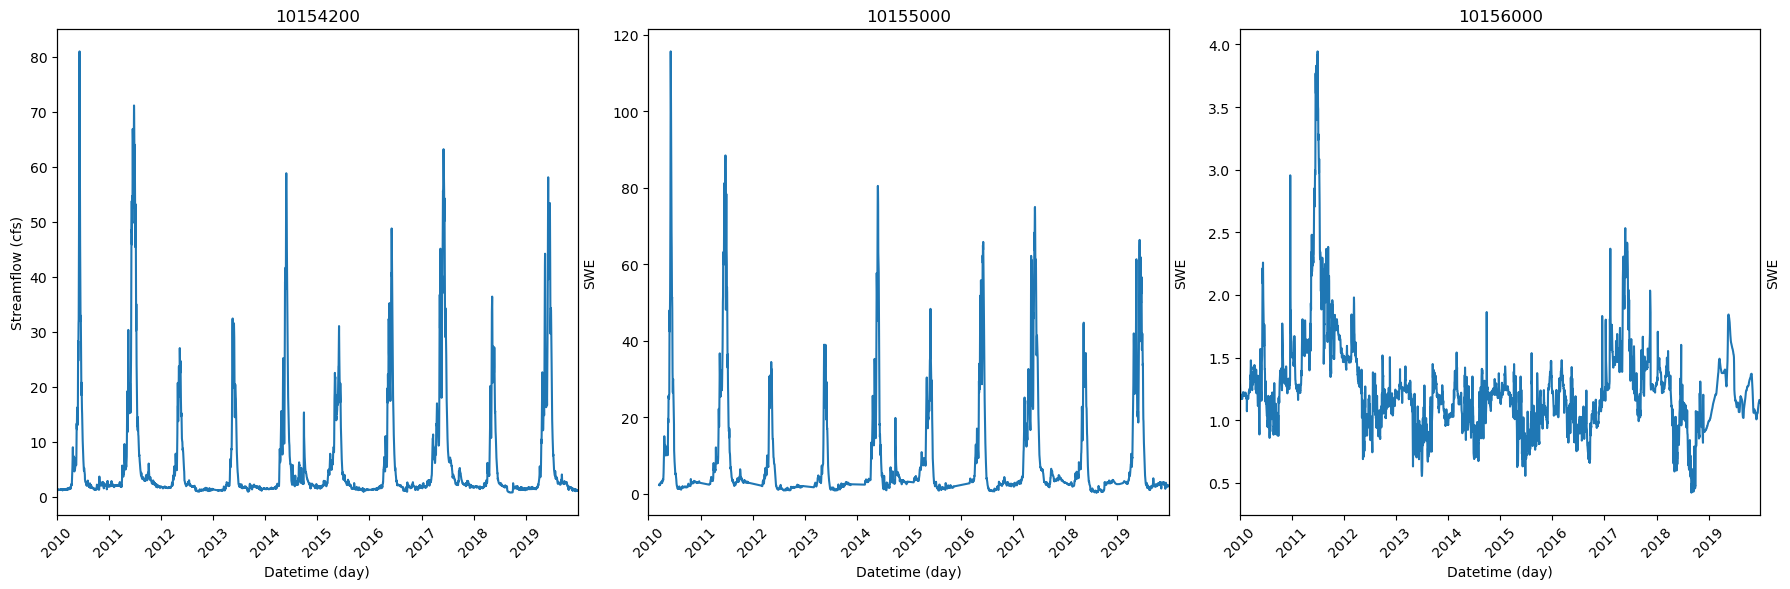

CPU times: user 11.2 s, sys: 38.5 ms, total: 11.3 s
Wall time: 11.3 s


In [4]:
%%time
# Initialize variables for the number of plots, columns, and rows based on the number of unique stations.
n_subplots = len(station_list)
n_cols = 3#int(math.ceil(math.sqrt(n_subplots)))  # Calculate columns as the ceiling of the square root of number of subplots.
n_rows = int(math.ceil(n_subplots / n_cols))  # Calculate rows as the ceiling of the ratio of subplots to columns.
figsize = (18, 6)  # Set the figure size for the plot.
# Create a figure and a grid of subplots with the specified number of rows and columns.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()  # Flatten the axes array for easier iteration.

# Iterate over each axis to plot data for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:  # Check if the current index is less than the number of subplots to populate.
        # Extract data for the current station.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]
        temp_df_1 = temp_df_1[(temp_df_1.datetime.dt.year >= year) & (temp_df_1.datetime.dt.year < year+10)]
        # Set 'datetime' as the index for the DataFrame for plotting.
        temp_df_2 = temp_df_1.set_index('datetime')
        # Plot 'flow_cfs' on the primary y-axis.
        ax.plot(temp_df_2.index, temp_df_2['flow_cms'])
        # Set x-axis limits from the minimum to maximum year of data.
        start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
        end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
        ax.set_xlim(start_year, end_year)
        # Get current x-tick labels and set their rotation for better visibility.
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45)

        # Create a secondary y-axis for Snow Water Equivalent (SWE).
        ax2 = ax.twinx()
        # Plot SWE as a bar graph on the secondary y-axis.
        ax2.bar(temp_df_2.index, temp_df_2['swe'], label='Inverted', color='red')
        # Set the y-axis limits for SWE, flipping the axis to make bars grow downward.
        ax2.set_ylim(max(temp_df_2['swe']) + 40, 0)
        # Set label for the secondary y-axis.
        ax2.set_ylabel('SWE')
        # Define custom ticks for the secondary y-axis.
        ax2.set_yticks(np.arange(0, max(temp_df_2['swe']), 5))

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Datetime (day)')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Streamflow (cfs)')
    else:
        # Hide any unused axes.
        ax.axis('off')

# Adjust the layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


Next, we will use histograms for streamflow to see its skewness and distribution. 

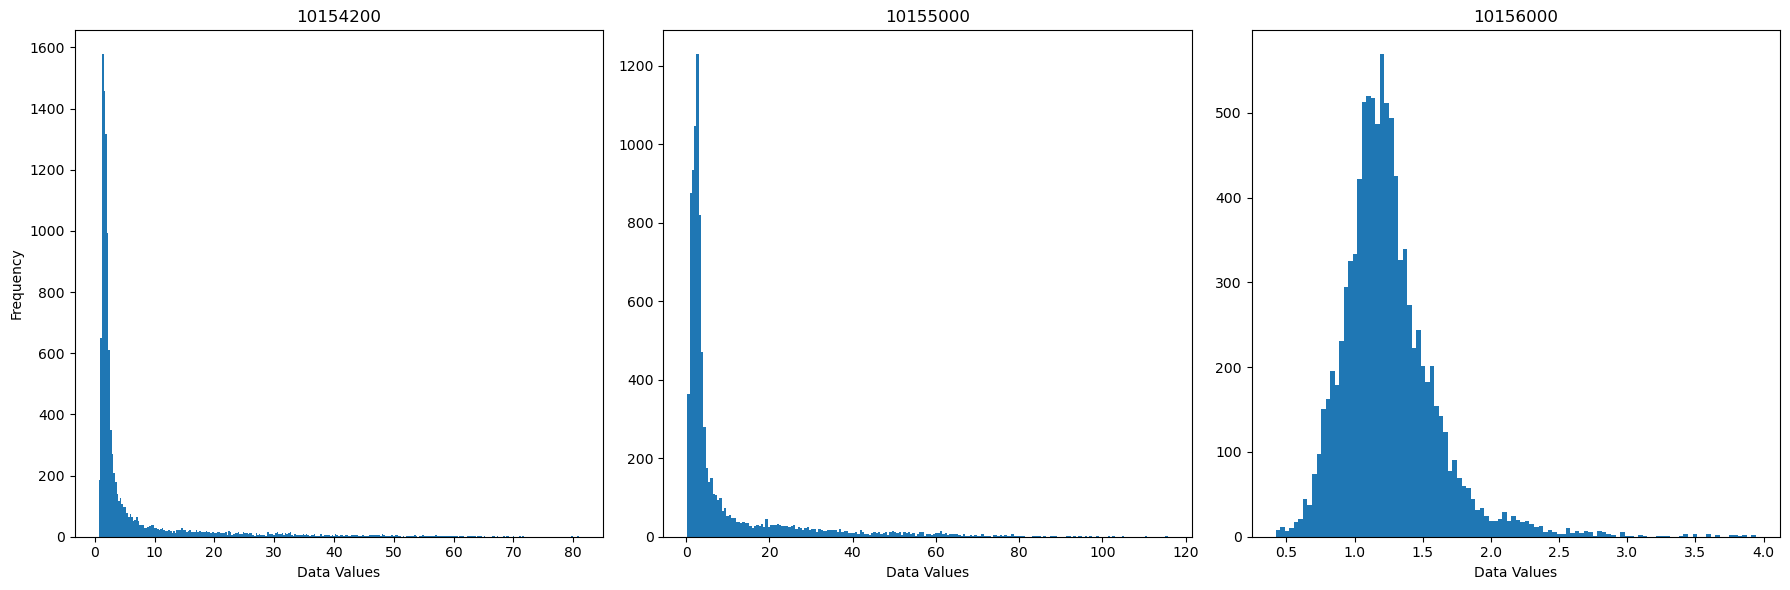

CPU times: user 1.03 s, sys: 14.9 ms, total: 1.05 s
Wall time: 1.05 s


In [5]:
%%time
# Determine the number of subplots based on the number of unique stations.
n_subplots = len(station_list)
# Calculate the number of columns for subplots based on the square root of the number of subplots.
n_cols = 3#int(math.ceil(math.sqrt(n_subplots)))
# Calculate the number of rows for subplots based on the total subplots and columns.
n_rows = int(math.ceil(n_subplots / n_cols))
# Set the size of the figure for subplots.
figsize = (18, 6)
# Create a figure and a grid of subplots with the specified rows and columns, and figure size.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()  # Flatten the axes array for easier access in looping.

# Loop through each axis to plot histogram for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:
        # Extract the data for the current station.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]

        # Calculate the Interquartile Range (IQR) for the 'flow_cfs' data.
        IQR = np.percentile(temp_df_1['flow_cms'], 75) - np.percentile(temp_df_1['flow_cms'], 25)
        # Calculate the bin width using Freedman-Diaconis rule which is optimal for histogram.
        bin_width = 2 * IQR * (len(temp_df_1['flow_cms']) ** (-1/3))
        # Calculate the number of bins for the histogram using the calculated bin width.
        bins_fd = int((max(temp_df_1['flow_cms']) - min(temp_df_1['flow_cms'])) / bin_width)

        # Plot a histogram of 'flow_cfs' for the station with calculated bins.
        ax.hist(temp_df_1['flow_cms'], bins=bins_fd)

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Data Values')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Frequency')
    else:
        # Hide unused subplots.
        ax.axis('off')

# Adjust the layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


#### 3.4. Splitting the Data
We split 80 percent of the data for trainging and the rest for testing the model, but we do not shuffele the data since LSTM needs to get the data in the right temporal sequence to understand the temporal relationships. So we will split the data based on the dates, 1986-2014 (80%) training and 2014-2020 (20%) testing. 
 


In [6]:
data_train, data_test = data_split(dataset)

#### 3.5. Scaling the Data and Adding Lookbacks 
- To use Neural Network models, such as LSTM we need to scale the data between zero and one since the scale of data for each feature can be very different than the other ones. Different scales hinders the model from learning. There are several functions for scaling or you can even create your own function, but for this tutoral we will use the famous MinMax() function from Sklearn library. 
- LSTM needs data from previous time steps with lag to capture the temporal relationship in the data. So we add the data with lag to our dataset and call it lookbacks. 
- A time series of n timesteps can produce approximately n lookbacks (e.g., a window can start at any time step given the lookbacks does not exceed the boundaries of the time series).
- Since we are using Pytorch we need to convert our data to Tensors with three dimensions. The first dimension will show us the batch size, number of the lookbacks will be the second dimension, and the third column will show the number of features. 
- For example, if our batc size is 100 with three features and four step lookbacks, the Tensor of input data would have (100, 4, 3) dimension. The four step lookbacks means, if our goal is to predict t+1 step the model would use the data from t, t-1, t-2, and t-3 time steps. 
- Druing adding the lookbacks we will also seperate the features and target datasets.  

In [7]:
length_lookback = 2
x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, scaler_x, scaler_y, y_train, x_test, y_test = data_prepare(data_train, data_test, length_lookback=length_lookback)

In [8]:
data_train.to_pickle(f"{output_path}train_dataset.pkl")
data_test.to_pickle(f"{output_path}test_dataset.pkl")
dataset.to_pickle(f"{output_path}dataset.pkl")

[**LETS GO TO THE NEXT PART**](./02.tutorial_post_processing_lstm_automatic_tuning.ipynb)